In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as albu

import time
import os
from tqdm.notebook import tqdm

from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
DATA_DIR = '../data/CamVid/'

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
#Train用、Val用、Test用の画像数の確認

print('the number of image/label in the train: ',len(os.listdir(x_train_dir)))
print('the number of image/label in the validation: ',len(os.listdir(x_valid_dir)))
print('the number of image/label in the test: ',len(os.listdir(x_test_dir)))

the number of image/label in the train:  367
the number of image/label in the validation:  101
the number of image/label in the test:  233


In [6]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [7]:
#Trainデータの確認

dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'pedestrian'])

image, mask = dataset[0] # get some sample

In [8]:
#画像およびマスクの表示用関数

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


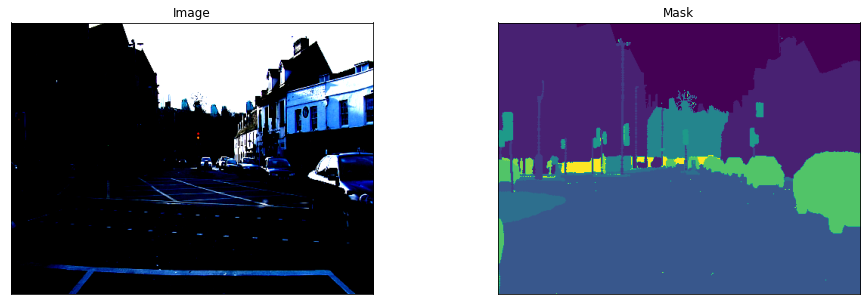

In [9]:
# Datasetの画像とマスクの確認。

dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'pedestrian'])

image, mask = dataset[0] # get some sample
visualize(
    image=image.permute(1, 2, 0), #To tensorでchannel, h, wが画像表示用と異なるため、配列変換
    mask=mask
)


In [10]:
def get_training_augmentation():
    train_transform = [


        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480),
        
    ]
    return albu.Compose(test_transform)

def test_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    #test_transform = [
    #   albu.PadIfNeeded(384, 480)
    #]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


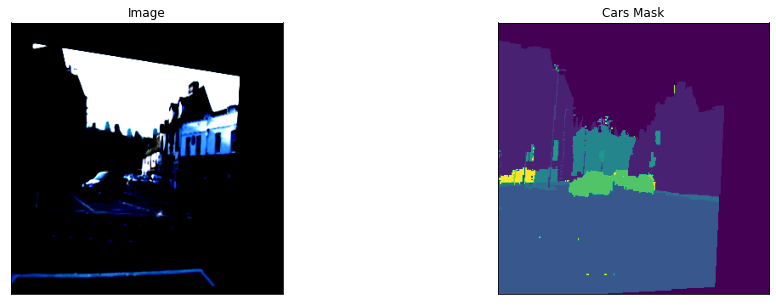

In [52]:
# Augumentation処理後の画像の確認

dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'pedestrian'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image.permute(1, 2, 0), 
    cars_mask=mask
)

In [12]:
#画像サイズの確認

image.shape

torch.Size([3, 320, 320])

## Create model and train

In [13]:
#画像のクラスを設定

CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'fence', 'car', 'pedestrian', 'bicyclist', 'unlabelled']

In [14]:
#Semantic Segmentationのモデルを設定

model = smp.Unet('efficientnet-b4', encoder_weights='imagenet', classes=len(CLASSES), activation=None)

In [15]:
#Train, Validationのデータセットを作成

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [16]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

## Training

In [17]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [18]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=len(CLASSES)):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    #torch.save(model, 'Unet-_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader))) #Train途中もモデルを保存するときは実行する
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 20:
                    print('Loss not decrease for 20 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [20]:
max_lr = 1e-3
epoch = 100
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, valid_loader, criterion, optimizer, sched)


Loss Decreasing.. inf >> 2.528 
Epoch:1/100.. Train Loss: 2.590.. Val Loss: 2.528.. Train mIoU:0.033.. Val mIoU: 0.043.. Train Acc:0.121.. Val Acc:0.113.. Time: 0.25m



Loss Decreasing.. 2.528 >> 2.226 
Epoch:2/100.. Train Loss: 2.307.. Val Loss: 2.226.. Train mIoU:0.059.. Val mIoU: 0.062.. Train Acc:0.241.. Val Acc:0.172.. Time: 0.24m



Loss Decreasing.. 2.226 >> 1.828 
Epoch:3/100.. Train Loss: 1.987.. Val Loss: 1.828.. Train mIoU:0.090.. Val mIoU: 0.136.. Train Acc:0.355.. Val Acc:0.448.. Time: 0.25m



Loss Decreasing.. 1.828 >> 1.509 
saving model...
Epoch:4/100.. Train Loss: 1.634.. Val Loss: 1.509.. Train mIoU:0.167.. Val mIoU: 0.190.. Train Acc:0.581.. Val Acc:0.644.. Time: 0.25m



Loss Decreasing.. 1.509 >> 1.238 
Epoch:5/100.. Train Loss: 1.329.. Val Loss: 1.238.. Train mIoU:0.215.. Val mIoU: 0.232.. Train Acc:0.715.. Val Acc:0.742.. Time: 0.24m



Loss Decreasing.. 1.238 >> 1.007 
Epoch:6/100.. Train Loss: 1.098.. Val Loss: 1.007.. Train mIoU:0.231.. Val mIoU: 0.245.. Train Acc:0.754.. Val Acc:0.768.. Time: 0.24m



Loss Decreasing.. 1.007 >> 0.885 
Epoch:7/100.. Train Loss: 0.906.. Val Loss: 0.885.. Train mIoU:0.243.. Val mIoU: 0.247.. Train Acc:0.778.. Val Acc:0.771.. Time: 0.24m



Loss Decreasing.. 0.885 >> 0.728 
Epoch:8/100.. Train Loss: 0.784.. Val Loss: 0.728.. Train mIoU:0.254.. Val mIoU: 0.273.. Train Acc:0.787.. Val Acc:0.795.. Time: 0.24m



Loss Decreasing.. 0.728 >> 0.621 
saving model...
Epoch:9/100.. Train Loss: 0.712.. Val Loss: 0.621.. Train mIoU:0.296.. Val mIoU: 0.359.. Train Acc:0.806.. Val Acc:0.860.. Time: 0.24m



Loss Decreasing.. 0.621 >> 0.547 
Epoch:10/100.. Train Loss: 0.617.. Val Loss: 0.547.. Train mIoU:0.350.. Val mIoU: 0.380.. Train Acc:0.843.. Val Acc:0.871.. Time: 0.24m



Loss Decreasing.. 0.547 >> 0.510 
Epoch:11/100.. Train Loss: 0.549.. Val Loss: 0.510.. Train mIoU:0.364.. Val mIoU: 0.380.. Train Acc:0.857.. Val Acc:0.870.. Time: 0.24m



Loss Not Decrease for 1 time
Epoch:12/100.. Train Loss: 0.514.. Val Loss: 0.533.. Train mIoU:0.372.. Val mIoU: 0.388.. Train Acc:0.860.. Val Acc:0.862.. Time: 0.24m



Loss Decreasing.. 0.533 >> 0.457 
Epoch:13/100.. Train Loss: 0.488.. Val Loss: 0.457.. Train mIoU:0.382.. Val mIoU: 0.402.. Train Acc:0.864.. Val Acc:0.877.. Time: 0.24m



Loss Decreasing.. 0.457 >> 0.427 
Epoch:14/100.. Train Loss: 0.442.. Val Loss: 0.427.. Train mIoU:0.401.. Val mIoU: 0.405.. Train Acc:0.876.. Val Acc:0.881.. Time: 0.24m



Loss Not Decrease for 2 time
Epoch:15/100.. Train Loss: 0.436.. Val Loss: 0.435.. Train mIoU:0.403.. Val mIoU: 0.408.. Train Acc:0.876.. Val Acc:0.873.. Time: 0.24m



Loss Not Decrease for 3 time
Epoch:16/100.. Train Loss: 0.442.. Val Loss: 0.448.. Train mIoU:0.405.. Val mIoU: 0.402.. Train Acc:0.874.. Val Acc:0.862.. Time: 0.25m



Loss Decreasing.. 0.448 >> 0.408 
saving model...
Epoch:17/100.. Train Loss: 0.420.. Val Loss: 0.408.. Train mIoU:0.415.. Val mIoU: 0.400.. Train Acc:0.877.. Val Acc:0.869.. Time: 0.25m



Loss Not Decrease for 4 time
Epoch:18/100.. Train Loss: 0.407.. Val Loss: 0.447.. Train mIoU:0.413.. Val mIoU: 0.405.. Train Acc:0.881.. Val Acc:0.864.. Time: 0.24m



Loss Decreasing.. 0.447 >> 0.424 
Epoch:19/100.. Train Loss: 0.413.. Val Loss: 0.424.. Train mIoU:0.419.. Val mIoU: 0.416.. Train Acc:0.877.. Val Acc:0.873.. Time: 0.24m



Loss Not Decrease for 5 time
Epoch:20/100.. Train Loss: 0.387.. Val Loss: 0.426.. Train mIoU:0.428.. Val mIoU: 0.441.. Train Acc:0.885.. Val Acc:0.872.. Time: 0.24m



Loss Not Decrease for 6 time
Epoch:21/100.. Train Loss: 0.396.. Val Loss: 0.540.. Train mIoU:0.427.. Val mIoU: 0.402.. Train Acc:0.881.. Val Acc:0.839.. Time: 0.24m



Loss Decreasing.. 0.540 >> 0.383 
Epoch:22/100.. Train Loss: 0.374.. Val Loss: 0.383.. Train mIoU:0.439.. Val mIoU: 0.428.. Train Acc:0.887.. Val Acc:0.879.. Time: 0.24m



Loss Decreasing.. 0.383 >> 0.344 
Epoch:23/100.. Train Loss: 0.354.. Val Loss: 0.344.. Train mIoU:0.447.. Val mIoU: 0.468.. Train Acc:0.891.. Val Acc:0.892.. Time: 0.24m



Loss Not Decrease for 7 time
Epoch:24/100.. Train Loss: 0.372.. Val Loss: 0.364.. Train mIoU:0.450.. Val mIoU: 0.457.. Train Acc:0.884.. Val Acc:0.887.. Time: 0.24m



Loss Not Decrease for 8 time
Epoch:25/100.. Train Loss: 0.345.. Val Loss: 0.365.. Train mIoU:0.459.. Val mIoU: 0.458.. Train Acc:0.894.. Val Acc:0.885.. Time: 0.24m



Loss Not Decrease for 9 time
Epoch:26/100.. Train Loss: 0.347.. Val Loss: 0.386.. Train mIoU:0.470.. Val mIoU: 0.454.. Train Acc:0.893.. Val Acc:0.873.. Time: 0.24m



Loss Decreasing.. 0.386 >> 0.343 
Epoch:27/100.. Train Loss: 0.364.. Val Loss: 0.343.. Train mIoU:0.468.. Val mIoU: 0.475.. Train Acc:0.888.. Val Acc:0.894.. Time: 0.24m



Loss Not Decrease for 10 time
Epoch:28/100.. Train Loss: 0.336.. Val Loss: 0.353.. Train mIoU:0.484.. Val mIoU: 0.496.. Train Acc:0.896.. Val Acc:0.889.. Time: 0.24m



Loss Decreasing.. 0.353 >> 0.323 
saving model...
Epoch:29/100.. Train Loss: 0.321.. Val Loss: 0.323.. Train mIoU:0.500.. Val mIoU: 0.492.. Train Acc:0.900.. Val Acc:0.893.. Time: 0.25m



Loss Decreasing.. 0.323 >> 0.298 
Epoch:30/100.. Train Loss: 0.318.. Val Loss: 0.298.. Train mIoU:0.504.. Val mIoU: 0.512.. Train Acc:0.901.. Val Acc:0.898.. Time: 0.25m



Loss Not Decrease for 11 time
Epoch:31/100.. Train Loss: 0.316.. Val Loss: 0.423.. Train mIoU:0.507.. Val mIoU: 0.476.. Train Acc:0.901.. Val Acc:0.863.. Time: 0.24m



Loss Decreasing.. 0.423 >> 0.306 
Epoch:32/100.. Train Loss: 0.301.. Val Loss: 0.306.. Train mIoU:0.532.. Val mIoU: 0.581.. Train Acc:0.905.. Val Acc:0.904.. Time: 0.24m



Loss Decreasing.. 0.306 >> 0.279 
Epoch:33/100.. Train Loss: 0.321.. Val Loss: 0.279.. Train mIoU:0.525.. Val mIoU: 0.582.. Train Acc:0.899.. Val Acc:0.915.. Time: 0.24m



Loss Decreasing.. 0.279 >> 0.260 
Epoch:34/100.. Train Loss: 0.282.. Val Loss: 0.260.. Train mIoU:0.543.. Val mIoU: 0.611.. Train Acc:0.910.. Val Acc:0.920.. Time: 0.24m



Loss Not Decrease for 12 time
Epoch:35/100.. Train Loss: 0.274.. Val Loss: 0.264.. Train mIoU:0.549.. Val mIoU: 0.561.. Train Acc:0.913.. Val Acc:0.915.. Time: 0.25m



Loss Not Decrease for 13 time
Epoch:36/100.. Train Loss: 0.289.. Val Loss: 0.280.. Train mIoU:0.552.. Val mIoU: 0.589.. Train Acc:0.909.. Val Acc:0.907.. Time: 0.25m



Loss Decreasing.. 0.280 >> 0.265 
saving model...
Epoch:37/100.. Train Loss: 0.258.. Val Loss: 0.265.. Train mIoU:0.570.. Val mIoU: 0.606.. Train Acc:0.917.. Val Acc:0.919.. Time: 0.25m



Loss Not Decrease for 14 time
Epoch:38/100.. Train Loss: 0.283.. Val Loss: 0.302.. Train mIoU:0.563.. Val mIoU: 0.588.. Train Acc:0.909.. Val Acc:0.908.. Time: 0.24m



Loss Decreasing.. 0.302 >> 0.287 
Epoch:39/100.. Train Loss: 0.269.. Val Loss: 0.287.. Train mIoU:0.562.. Val mIoU: 0.609.. Train Acc:0.913.. Val Acc:0.910.. Time: 0.24m



Loss Decreasing.. 0.287 >> 0.269 
Epoch:40/100.. Train Loss: 0.260.. Val Loss: 0.269.. Train mIoU:0.580.. Val mIoU: 0.589.. Train Acc:0.918.. Val Acc:0.915.. Time: 0.25m



Loss Not Decrease for 15 time
Epoch:41/100.. Train Loss: 0.267.. Val Loss: 0.296.. Train mIoU:0.577.. Val mIoU: 0.584.. Train Acc:0.915.. Val Acc:0.905.. Time: 0.25m



Loss Not Decrease for 16 time
Epoch:42/100.. Train Loss: 0.294.. Val Loss: 0.300.. Train mIoU:0.559.. Val mIoU: 0.597.. Train Acc:0.906.. Val Acc:0.907.. Time: 0.24m



Loss Not Decrease for 17 time
Epoch:43/100.. Train Loss: 0.249.. Val Loss: 0.302.. Train mIoU:0.590.. Val mIoU: 0.608.. Train Acc:0.919.. Val Acc:0.910.. Time: 0.25m



Loss Decreasing.. 0.302 >> 0.291 
Epoch:44/100.. Train Loss: 0.239.. Val Loss: 0.291.. Train mIoU:0.606.. Val mIoU: 0.620.. Train Acc:0.922.. Val Acc:0.913.. Time: 0.24m



Loss Not Decrease for 18 time
Epoch:45/100.. Train Loss: 0.242.. Val Loss: 0.296.. Train mIoU:0.597.. Val mIoU: 0.619.. Train Acc:0.920.. Val Acc:0.909.. Time: 0.24m



Loss Decreasing.. 0.296 >> 0.279 
Epoch:46/100.. Train Loss: 0.224.. Val Loss: 0.279.. Train mIoU:0.615.. Val mIoU: 0.621.. Train Acc:0.926.. Val Acc:0.914.. Time: 0.24m



Loss Decreasing.. 0.279 >> 0.271 
saving model...
Epoch:47/100.. Train Loss: 0.238.. Val Loss: 0.271.. Train mIoU:0.610.. Val mIoU: 0.621.. Train Acc:0.922.. Val Acc:0.915.. Time: 0.24m



Loss Decreasing.. 0.271 >> 0.230 
Epoch:48/100.. Train Loss: 0.241.. Val Loss: 0.230.. Train mIoU:0.607.. Val mIoU: 0.639.. Train Acc:0.921.. Val Acc:0.927.. Time: 0.25m



Loss Not Decrease for 19 time
Epoch:49/100.. Train Loss: 0.223.. Val Loss: 0.271.. Train mIoU:0.633.. Val mIoU: 0.641.. Train Acc:0.926.. Val Acc:0.921.. Time: 0.25m



Loss Decreasing.. 0.271 >> 0.270 
Epoch:50/100.. Train Loss: 0.231.. Val Loss: 0.270.. Train mIoU:0.615.. Val mIoU: 0.618.. Train Acc:0.924.. Val Acc:0.918.. Time: 0.24m



Loss Not Decrease for 20 time
Loss not decrease for 20 times, Stop Training
Total time: 12.41 m


In [21]:
torch.save(model, 'Unet-efficientb4_qiita.pt')

In [22]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

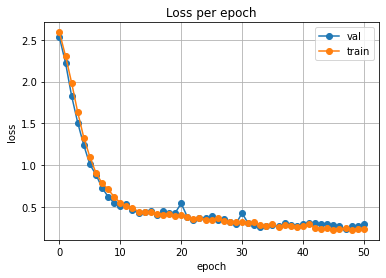

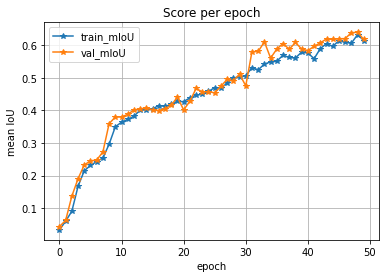

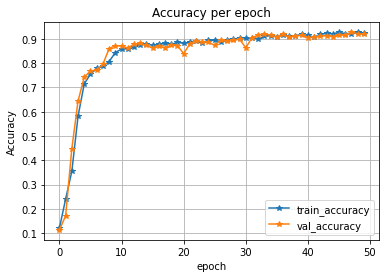

In [23]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Evaluation

## Test best saved model

In [24]:
# load best saved checkpoint
model = torch.load('Unet-efficientb4_qiita.pt')

In [25]:
class testDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        #t = T.Compose([T.ToTensor()])
        #image = t(image)
        mask = torch.from_numpy(mask).long()
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [26]:
# create test dataset
test_dataset = testDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    #preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [27]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [28]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [29]:
image, mask = test_dataset[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [30]:
image, mask = test_dataset[3]
image.shape

(384, 480, 3)

In [31]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [32]:
mob_miou = miou_score(model, test_dataset)
print('Test Set mIoU', np.mean(mob_miou))


Test Set mIoU 0.5398935530940476


In [33]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [34]:
mob_acc = pixel_acc(model, test_dataset)
print('Test Set Pixel Accuracy', np.mean(mob_acc))


Test Set Pixel Accuracy 0.8658704678558655


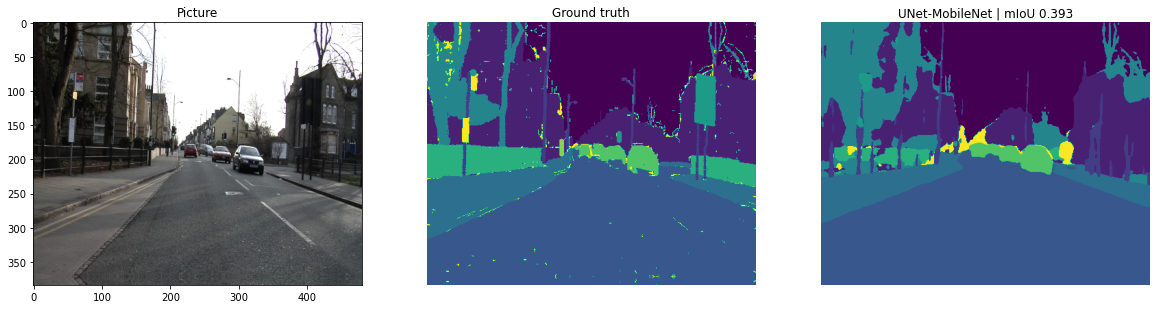

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

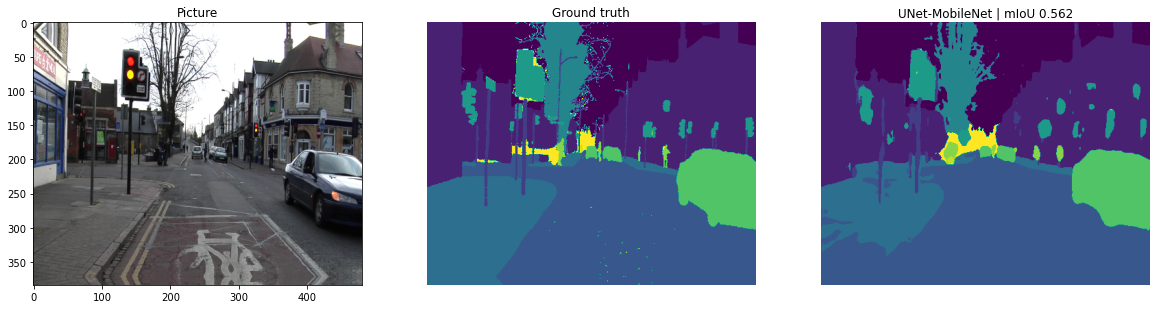

In [36]:
image2, mask2 = test_dataset[15]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [37]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

UNet-EfficientNet-B4 | mIoU 0.560


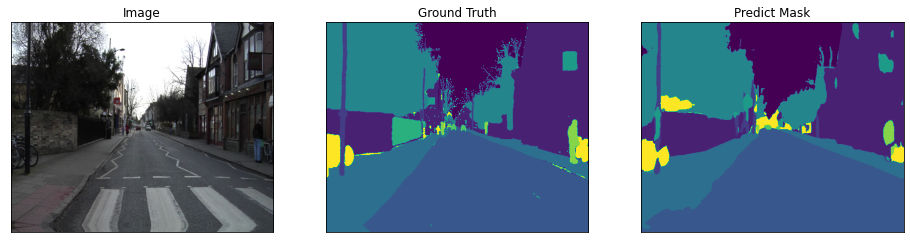

UNet-EfficientNet-B4 | mIoU 0.654


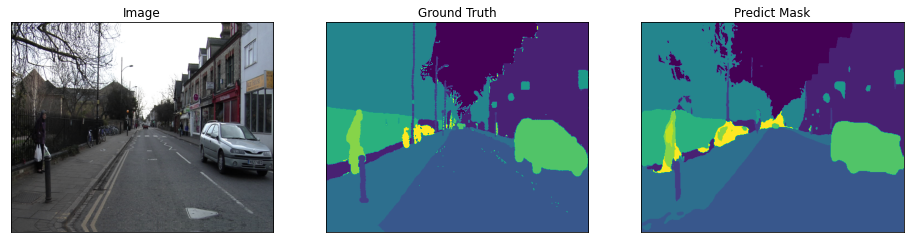

UNet-EfficientNet-B4 | mIoU 0.661


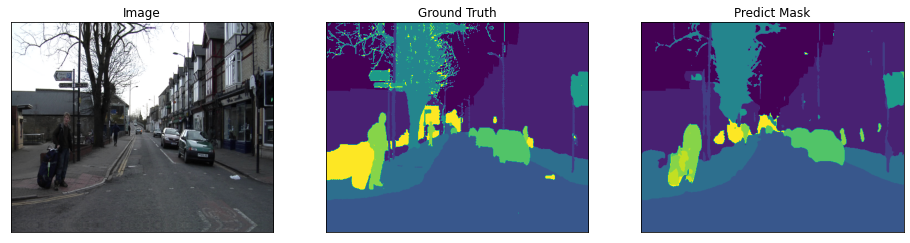

UNet-EfficientNet-B4 | mIoU 0.488


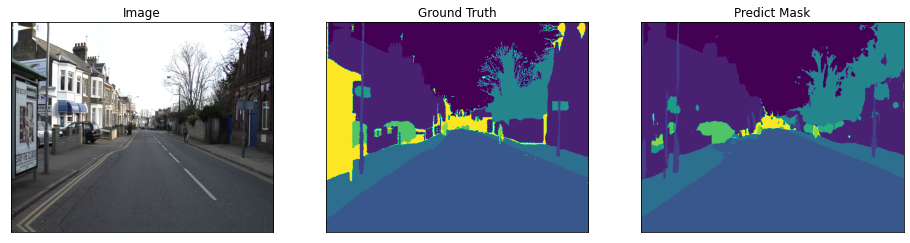

In [39]:
for i in range(4):
    n = np.random.choice(len(test_dataset))
    
    image2, mask2 = test_dataset[n]
    
    pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)
    
    print('UNet-EfficientNet-B4 | mIoU {:.3f}'.format(score2))
    
    visualize(
        image=image2, 
        ground_truth=mask2,
        predict_mask = pred_mask2,
    )
    